# Mobikwik

In [47]:
# Load necessary libraries
import sys
import warnings
warnings.filterwarnings('ignore')
import datetime
import pandas as pd
import gensim
import tqdm.notebook as tqdm
from tqdm.auto import tqdm
tqdm.pandas()

sys.path.append('/Users/pushkar/Documents/projects/fin_comp/comp/docs')

import utils.helper
from utils.helper import Processor
import importlib
importlib.reload(utils.helper)

import plotly.io as pio
svg_renderer = pio.renderers["svg"]
svg_renderer.width = 900
svg_renderer.height = 500
pio.renderers.default = "svg"
import plotly.express as px

In [2]:
# Load data
df = pd.read_csv('./../../data/fintech/mobikwik/mobikwik.csv')

In [25]:
# Company username
company_username = 'MobiKwikSWAT'

In [4]:
# Correct the format of variables
df['inReplyToTweetId'] = df['inReplyToTweetId'].apply(lambda x: '%.0f' % x).values.tolist()
df['conversation_id'] = df['conversation_id'].astype(str)

In [5]:
# Declare the query words
query_words = ['dm', 'customer experience', 'inconvenience', 'concern team', 'resolve', 
                'solve', 'no noc', 'await response', 'unpleasant experience']

In [6]:
# Declare the processor object
processor = Processor('./../../data/config.json')

In [7]:
# Check whether an observation is query for the company or not
df['is_query'] = 0

for word in tqdm(query_words):
    df['is_query'] = df['is_query'] + df['tweet'].apply(processor.word_distribution, find=word).astype(int)

  0%|          | 0/9 [00:00<?, ?it/s]

In [26]:
# Select observations of queries
qdf = df[(df['is_query']>0) & (df['username'] == company_username)]

In [27]:
qdf.shape

(237, 28)

In [28]:
# Get all the conversation ids
conversation_ids = qdf['conversation_id'].unique()
print(f"Total number of unique conversations: {len(conversation_ids)}")

Total number of unique conversations: 234


In [29]:
df['date'] = pd.to_datetime(df['date'])

## Response time

Response time is the time the company takes to respond to the first query.

In [30]:
result = pd.DataFrame()
result['conversation_id'] = conversation_ids
result['response_time'] = 0

In [31]:
for index, conversation_id in enumerate(conversation_ids):
    tmp = df[df['conversation_id'] == conversation_id]
    tmp.sort_values('date', ascending=True, inplace=True)
    comp_tmp = tmp[tmp['username'] == company_username]
    response_time = (comp_tmp.iloc[0]['date'] - tmp.iloc[0]['date']) / datetime.timedelta(hours=1)
    result.at[index, 'response_time'] = response_time

In [32]:
result

,conversation_id,response_time
0,1343398089277595648,0.000000
1,1335260303009882112,0.000000
2,1333639022715944960,143.658889
3,1333048476918116352,0.000000
4,1333021985534668802,0.000000
...,...,...
229,1083275847778222080,0.000000
230,1082941120399560704,0.082500
231,1082865424310517761,27.335556
232,1082938998773989376,0.000000


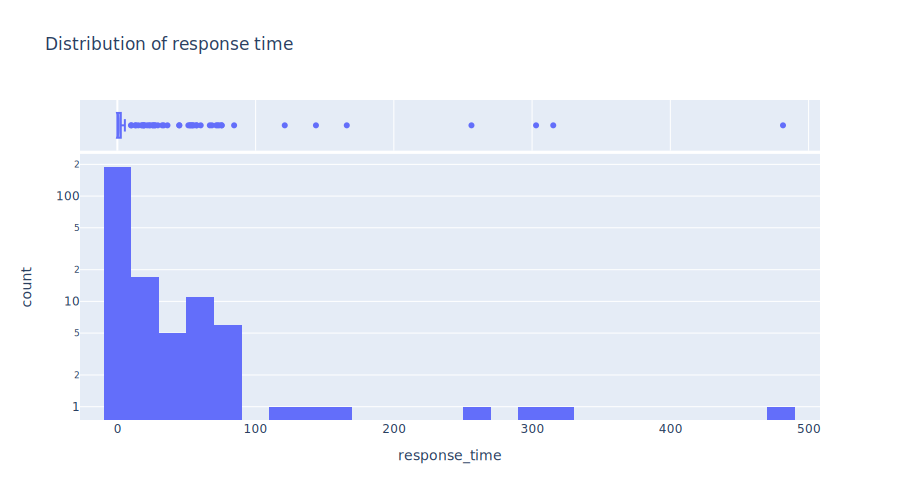

In [35]:
fig = px.histogram(result, x='response_time', log_y=True, marginal='box', title='Distribution of response time')
fig.show()

In [37]:
df[df['conversation_id'] == '1335260303009882112']

,tweet,conversation_id,date,hashtags,id,inReplyToTweetId,reply_to,language,likes_count,media,...,favourites_count,user_status_count,location,name,description,verified,url,user_id,username,is_query
1567,@Akshaynachankar We are glad that your issue h...,1335260303009882112,2020-12-08 03:46:00+00:00,NaN,1336155039874727937,1336005306766172160,https://twitter.com/Akshaynachankar,en,0,NaN,...,2718,232171,India,MobiKwik Support,Official Support handle of @MobiKwik | We're h...,True,https://www.mobikwik.com/help,3037981994,MobiKwikSWAT,2


https://twitter.com/MobiKwikSWAT/status/1343765688704331776

https://twitter.com/MobiKwikSWAT/status/1336155039874727937

## Resolution time

Assuming that if the last query in the conversation is from the company then the issue is resolved.  
Resolution time is the time difference between the last date of last tweet in the conversation and the date of first query.

In [38]:
result['resolution_time'] = 0

In [39]:
for index, conversation_id in enumerate(conversation_ids):
    tmp = df[df['conversation_id'] == conversation_id]
    tmp.sort_values('date', ascending=True, inplace=True)
    comp_tmp = tmp[tmp['username'] == company_username]
    if tmp.iloc[-1]['username'] == company_username:
        resolution_time = (tmp.iloc[-1]['date'] - tmp.iloc[0]['date']) / datetime.timedelta(hours=1)
        result.at[index, 'resolution_time'] = resolution_time

In [40]:
print(f"Number of queries resolved: {len(result['resolution_time'].to_numpy().nonzero()[0])}")
print(f"Number of queries unresolved: {result.shape[0] - len(result['resolution_time'].to_numpy().nonzero()[0])}")

Number of queries resolved: 105
Number of queries unresolved: 129


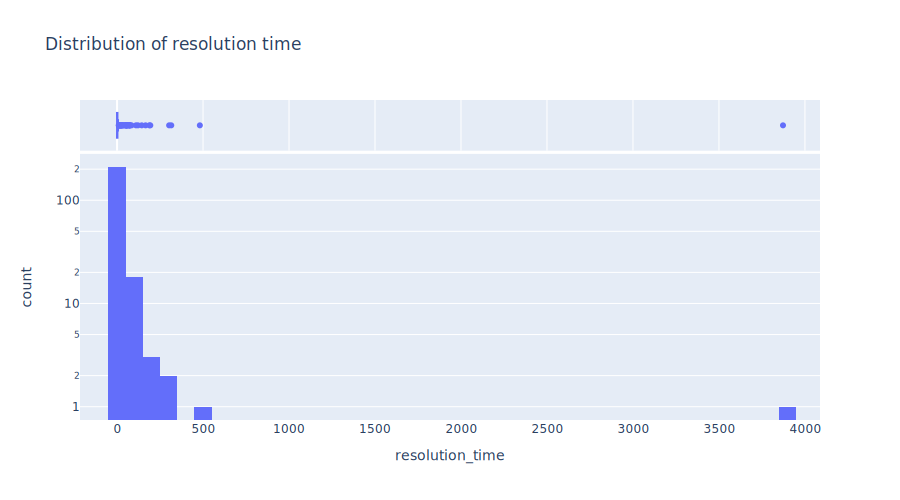

In [41]:
fig = px.histogram(result, x='resolution_time', log_y=True, marginal='box', title='Distribution of resolution time')
fig.show()

In [42]:
result.describe()

,response_time,resolution_time
count,234.000000,234.000000
mean,14.938972,31.573590
std,50.127574,257.168860
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,2.466319,2.240278
max,481.504167,3872.435000


## Query Tweets Topics


In [43]:
queries = df[df['conversation_id'].isin(conversation_ids)]
queries.sort_values('date', ascending=True, inplace=True)
queries = queries[queries['inReplyToTweetId'] == 'nan']
queries.shape


(138, 28)

In [48]:
processor = Processor('./../../data/config.json')
queries = processor.preprocess_individual(queries)
id2word = gensim.corpora.Dictionary(queries['bigram'].values.tolist())
corpus = [id2word.doc2bow(text) for text in queries['bigram'].values.tolist()]


In [49]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                        id2word=id2word,
                                        num_topics=4,
                                        random_state=100,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True,
                                        alpha=0.3,
                                        eta=0.3)
coherence_model = gensim.models.CoherenceModel(model=lda_model, 
                                                    texts=queries['bigram'].values.tolist(), 
                                                    dictionary=id2word, 
                                                    coherence='u_mass')
coherence_model_score = coherence_model.get_coherence()
print('Coherence Score: ', coherence_model_score)
import pyLDAvis.gensim_models

import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared


Coherence Score:  -13.345493014034385


/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/en

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.121963  0.040180       1        1  31.129835
3      0.083766  0.064748       2        1  27.133339
1      0.035350 -0.006905       3        1  22.681459
0      0.002847 -0.098023       4        1  19.055367, topic_info=                Term       Freq      Total Category  logprob  loglift
18            thanks  10.000000  10.000000  Default  30.0000  30.0000
33              bank   7.000000   7.000000  Default  29.0000  29.0000
63       transaction  13.000000  13.000000  Default  28.0000  28.0000
29            ticket   5.000000   5.000000  Default  27.0000  27.0000
527  indian_payments   6.000000   6.000000  Default  26.0000  26.0000
..               ...        ...        ...      ...      ...      ...
91           getting   1.329034   3.171513   Topic4  -5.4102   0.7881
15       information   1.325772   5.844084   Topic4  -5.4126   0.1744
12      confidential   1.323187   5.235061   Topic4  -5.4146   0.2825
72            number   1.321980   5.078744   Topic4  -5.4155   0.3119
100           issues   1.320021   3.765193   Topic4  -5.4170   0.6097

[242 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
276       4  0.526822     able
746       2  0.486854       ac
189       3  0.736205   accept
32        1  0.144453  account
32        2  0.361133  account
...     ...       ...      ...
163       4  0.469272    worst
642       4  0.809284       ye
202       3  0.736205     year
236       4  0.526864  youtube
682       4  0.755286     zoom

[301 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1])

In [50]:
queries_topic_sents_keywords = processor.dominant_topics(ldamodel=lda_model, 
                                                         corpus=corpus, 
                                                         texts=queries['bigram'].values.tolist(),
                                                         tweets=queries['tweet'].values.tolist())
queries_topic_sents_keywords['Topic_Keywords'].unique()


array(['app, thanks, dm, continue_truly, indian_payments, till, users, payment, kindly, im',
       'ticket, payment, id, order, wallet, money, help, account, worst, raised',
       'app, transaction, money, bank, account, payment, refund, deducted, recharge, help',
       'account, transaction, card, money, cashback, supercash, indian, rs, customer, service'],
      dtype=object)

In [51]:
select = queries_topic_sents_keywords['Topic_Keywords'].unique()[1]
queries_topic_sents_keywords[queries_topic_sents_keywords['Topic_Keywords'] == select]['Text'].values


array(['Make the right choice!\nNow you can choose to earn #Supercash or use your #SuperCash. https://t.co/MNsGqDpUdI',
       'Dear @MobiKwik can you expedite my request to delete my account. I am getting unauthorized messages and emails of OTP many times daily for new device login. Please do the needful @BipinSingh @UpasanaTaku',
       '@MobiKwik says that any fraud happening on their wallet is not their responsibility. How is allowing a transaction without any OTP or Password even allowed by @MobiKwikSWAT. \nI hope @RBI is looking into this. @BipinSingh @UpasanaTaku are you listening?',
       '@MobiKwik @MobiKwikSWAT \nWorst ever app ..\nFighting for KYc since once week..\nNo centre is doing kyc listed in the kyc center..\nMy amount is blocked due to worst service.\nCc number is only having IVR.\nMobikwik wallet number 9599282930\nNeed urgent attention on this',
       'Boost your finances with Instant Loans on MobiKwik! No security needed! Just give your basic details and It’s Ta

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



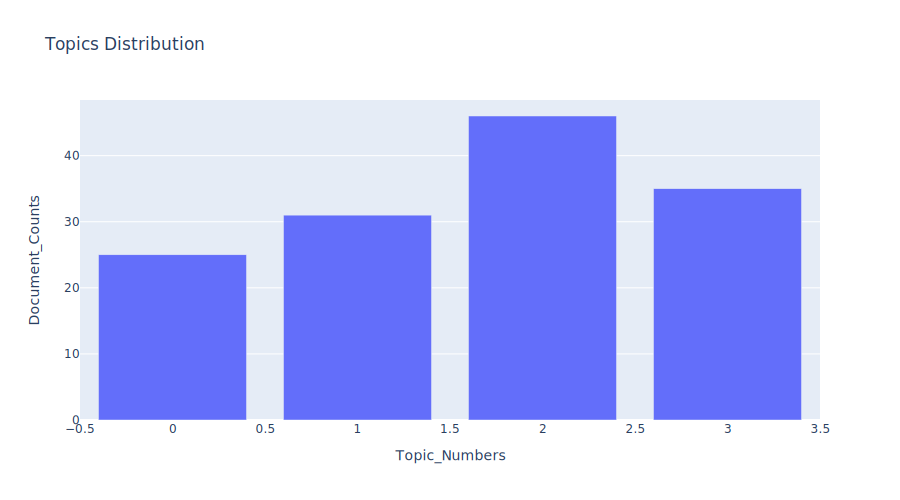

In [52]:
queries_dist, fig = processor.plot_topic_distribution(queries_topic_sents_keywords)
fig.show()